
- Applying model and Gridsearch


In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow_addons.metrics import RSquare
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dropout

In [4]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)

with open("data/full_features/lasso/testdt.pkl", 'rb') as f:
   _, ytest_df =  pickle.load(file = f)
with open("data/full_features/lasso/traindt-tf.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/lasso/testdt-tf.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)

In [5]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, ytest_df.shape

((738, 34), (104, 34), (738,), (104,), (104, 1))

Set up experiment, Spliting data


In [6]:
import logging
import random
logging.getLogger('tensorflow').disabled = True 
seed = 12345

In [7]:
# spliting data to visualize chosen networks
random.seed(seed)
xtrain_, xval_, ytrain_, yval_ = train_test_split(xtrain, ytrain, test_size=0.20, random_state=42)

In [8]:
xval_.shape, yval_.shape

((148, 34), (148,))

In [9]:
xtrain_.shape, ytrain_.shape

((590, 34), (590,))

Get measure functions, summary Grid results


In [10]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

## Model implementation


### Neural Networks


In [11]:
# Building plot function 

def plot_history(model_hist, expname, epochs =200):
    res = pd.DataFrame(model_hist.history)
    res_dic = {'loss - MSE':{'train':res['loss'], 'val':res['val_loss']},
                'r2': {'train':res['r_square'], 'val':res['val_r_square']}}
    x = range(1, epochs+1)
    fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
    measures = list(res_dic.keys())
    for i, m in enumerate(measures):
        ax[i].plot(x, res_dic[m]['train'], label = f'training{m}')
        ax[i].plot(x, res_dic[m]['val'], label = f'training{m}')
        ax[i].set_ylabel(measures[i])   
        ax[i].set_title(f'Training and validation {m} {expname}')
        ax[i].legend(['training', 'validation'])
        ax[i].grid(visible=True)
    plt.xlabel('Epochs')
    plt.show()

In [12]:
#plot comparation

def plot_comparation(data_list, label_list, title, ylabel, epochrange):
    epochs = range(epochrange[0]+1, epochrange[1]+1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data[epochrange[0]: epochrange[1]], label=label)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [13]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [14]:
def get_best_epochs(model_hist):
   model_loss = model_hist.history["val_loss"]
   epoch_chosen = model_loss.index(min(model_loss)) +1
   print(f'Best number of epochs {epoch_chosen}')

In [15]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

MLP


In [16]:
# Finding the best Number of hidden layers
mlp_gridlayers = {'hidden_layer_sizes': [(64, 8),
                                         (64, 16, 8),
                                         (128, 16, 8),
                                         (128, 32, 8),
                                         (128, 64, 8),
                                         (128, 64, 16),
                                         (128, 64, 16, 8),
                                         (256, 128, 16, 8),
                                         (256, 128, 32, 8),
                                         (256, 128, 64, 8),
                                         (256, 128, 64, 16),
                                         (256, 128, 64, 32),
                                         (128, 128, 128, 64, 16),
                                         (256, 128, 128, 64, 8),
                                         (256, 256, 128, 128, 64),
                                         (256, 128, 64, 16, 8),
                                         (256, 128, 64, 32, 8),
                                         (256, 128, 64, 32, 16),
                                         (256, 128, 64, 64, 8),
                                         (256, 128, 64, 64, 16),
                                         (256, 128, 64, 32, 16, 8),]}

random.seed(seed)
mlp = MLPRegressor(max_iter=200, early_stopping=True)  # default by the rest
grid_layers = GridSearchCV(mlp, mlp_gridlayers, cv=4,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_result_layer = grid_layers.fit(xtrain, ytrain)


In [17]:
summaryGridresult(grid_result_layer, 'Best results for Hidden layers structures', 10)

Best results for Hidden layers structures
Best: 0.672917 using {'hidden_layer_sizes': (256, 128, 32, 8)}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
8,"{'hidden_layer_sizes': (256, 128, 32, 8)}",0.841895,0.073155,0.672917,0.073155
17,"{'hidden_layer_sizes': (256, 128, 64, 32, 16)}",0.814484,0.045713,0.672175,0.045713
7,"{'hidden_layer_sizes': (256, 128, 16, 8)}",0.811093,0.046166,0.671672,0.046166
9,"{'hidden_layer_sizes': (256, 128, 64, 8)}",0.861860,0.051519,0.670549,0.051519
4,"{'hidden_layer_sizes': (128, 64, 8)}",0.824752,0.062868,0.662033,0.062868
14,"{'hidden_layer_sizes': (256, 256, 128, 128, 64)}",0.820598,0.027755,0.659773,0.027755
1,"{'hidden_layer_sizes': (64, 16, 8)}",0.820277,0.047178,0.658318,0.047178
18,"{'hidden_layer_sizes': (256, 128, 64, 64, 8)}",0.834729,0.058874,0.657468,0.058874
20,"{'hidden_layer_sizes': (256, 128, 64, 32, 16, 8)}",0.810385,0.051183,0.655589,0.051183
13,"{'hidden_layer_sizes': (256, 128, 128, 64, 8)}",0.778282,0.064504,0.642966,0.064504


In [18]:
# Build baseline network with Keras
#network = [256, 128, 64, 16, 8]
#kernel_init = 'uniform'
#acti = 'relu'
#opt = 'adam'
n_feat = xtrain.shape[1]
chosenNetwork = grid_result_layer.best_params_['hidden_layer_sizes']
def create_mlpbl():
   network =chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = 'uniform', 
                  activation='relu' , input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model
#network = np.array([256, 128, 64, 16])
mlpbl = create_mlpbl()
mlpbl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8960      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 46,257
Trainable params: 46,257
Non-trainable params: 0
_________________________________________________________________


In [19]:
tf.random.set_seed(seed)
random.seed(seed)
mlpbl = create_mlpbl()
mlpbl_hist = mlpbl.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=128,
                      validation_data=(xval_, yval_),
                      verbose=0)

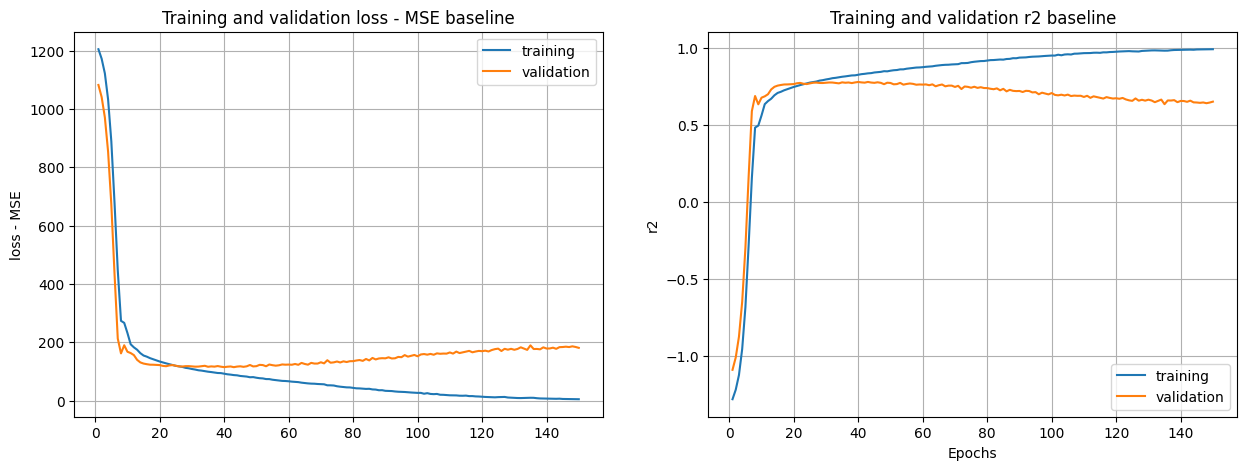

In [20]:
plot_history(mlpbl_hist,'baseline',150)

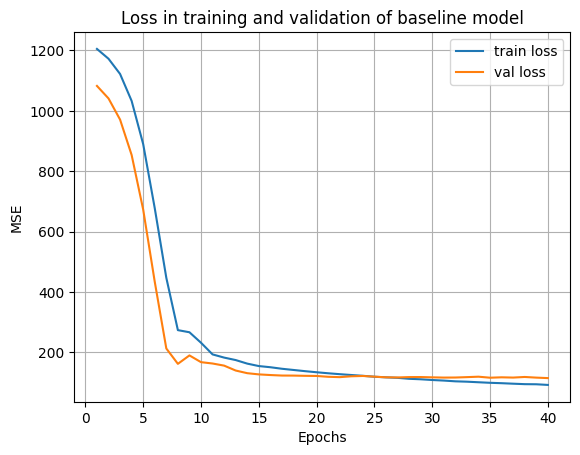

In [21]:
loss_train = mlpbl_hist.history['loss']
loss_val = mlpbl_hist.history['val_loss']


plot_comparation(data_list=[loss_train,loss_val], 
               label_list=['train loss', 'val loss'],
               title='Loss in training and validation of baseline model',
               ylabel='MSE',
               epochrange=(0,40))

In [22]:
get_best_epochs(mlpbl_hist)

Best number of epochs 43


### choose batch size

In [23]:
# default params as baseline

# Grid params
batch_size = np.array([8, 16, 32, 64, 128])
epochs = np.arange(0,30)
batch_pams = dict(batch_size=batch_size, epochs=epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)

mlp = KerasRegressor(model=create_mlpbl, verbose=0)
grid_batch = GridSearchCV(mlp, batch_pams, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_batch = grid_batch.fit(xtrain, ytrain)
summaryGridresult(grid_result_batch, 'Top batch-sizes by ep/ochs', 10)


c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top batch-sizes by ep/ochs
Best: 0.693316 using {'batch_size': 32, 'epochs': 18}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
78,"{'batch_size': 32, 'epochs': 18}",0.823504,0.040410,0.693316,0.040410
6,"{'batch_size': 8, 'epochs': 6}",0.807800,0.040885,0.685968,0.040885
116,"{'batch_size': 64, 'epochs': 26}",0.832688,0.052527,0.685586,0.052527
79,"{'batch_size': 32, 'epochs': 19}",0.844731,0.042097,0.684334,0.042097
114,"{'batch_size': 64, 'epochs': 24}",0.807531,0.046692,0.684116,0.046692
8,"{'batch_size': 8, 'epochs': 8}",0.824665,0.052402,0.683745,0.052402
111,"{'batch_size': 64, 'epochs': 21}",0.818896,0.060367,0.683631,0.060367
76,"{'batch_size': 32, 'epochs': 16}",0.836383,0.053171,0.683388,0.053171
75,"{'batch_size': 32, 'epochs': 15}",0.828553,0.055415,0.681467,0.055415
12,"{'batch_size': 8, 'epochs': 12}",0.847308,0.054881,0.679001,0.054881


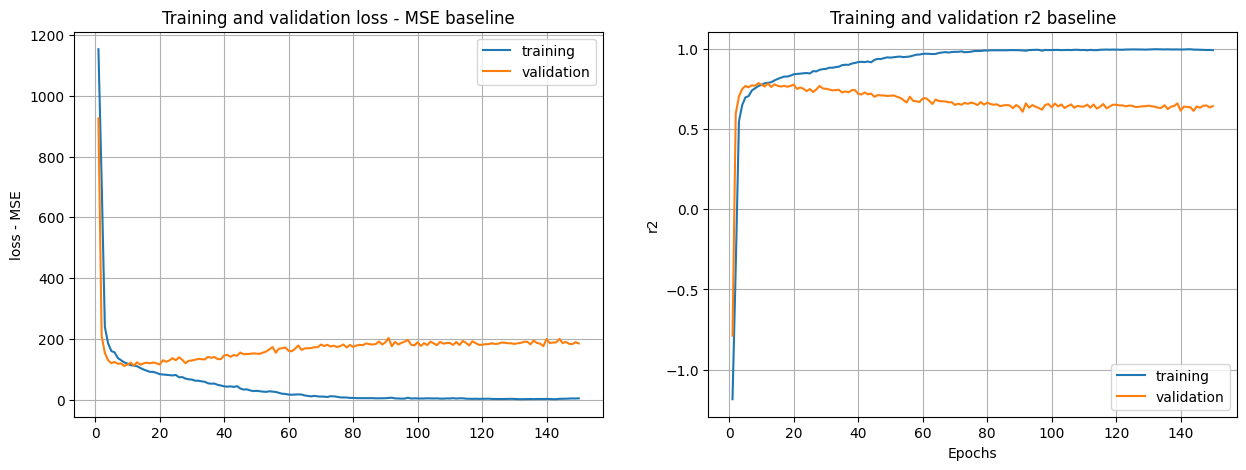

In [24]:
chosenBatch = grid_result_batch.best_params_['batch_size']
tf.random.set_seed(seed)
random.seed(seed)
mlp = create_mlpbl()
mlpbl_hist = mlp.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlpbl_hist,'baseline',150)

In [25]:
get_best_epochs(mlpbl_hist)

Best number of epochs 9


### Kernel initializer

In [26]:
### Kernel initializer

def create_mlpk(k_init = 'uniform'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = k_init, 
                  activation='relu', input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
k_init = ['uniform', 'normal', 'glorot_normal', 'glorot_uniform',]
epochs = np.arange(0,30)

pams_grid = dict(model__k_init= k_init,  
               epochs = epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)
mlp = KerasRegressor(model = create_mlpk,
                     batch_size = chosenBatch,
                     verbose=0)
grid_kn = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_kn = grid_kn.fit(xtrain, ytrain)


pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_kn, 'Top results for inititalization' , 10)


Top results for inititalization
Best: 0.691928 using {'epochs': 19, 'model__k_init': 'glorot_normal'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
78,"{'epochs': 19, 'model__k_init': 'glorot_normal'}",0.844958,0.054020,0.691928,0.054020
96,"{'epochs': 24, 'model__k_init': 'uniform'}",0.868750,0.052845,0.685417,0.052845
62,"{'epochs': 15, 'model__k_init': 'glorot_normal'}",0.827225,0.051011,0.685241,0.051011
61,"{'epochs': 15, 'model__k_init': 'normal'}",0.821639,0.048221,0.685198,0.048221
57,"{'epochs': 14, 'model__k_init': 'normal'}",0.816284,0.053024,0.684351,0.053024
69,"{'epochs': 17, 'model__k_init': 'normal'}",0.837034,0.053623,0.682074,0.053623
86,"{'epochs': 21, 'model__k_init': 'glorot_normal'}",0.877010,0.050017,0.682025,0.050017
91,"{'epochs': 22, 'model__k_init': 'glorot_uniform'}",0.860548,0.043474,0.681587,0.043474
87,"{'epochs': 21, 'model__k_init': 'glorot_uniform'}",0.867090,0.053486,0.680159,0.053486
45,"{'epochs': 11, 'model__k_init': 'normal'}",0.794129,0.046145,0.679269,0.046145


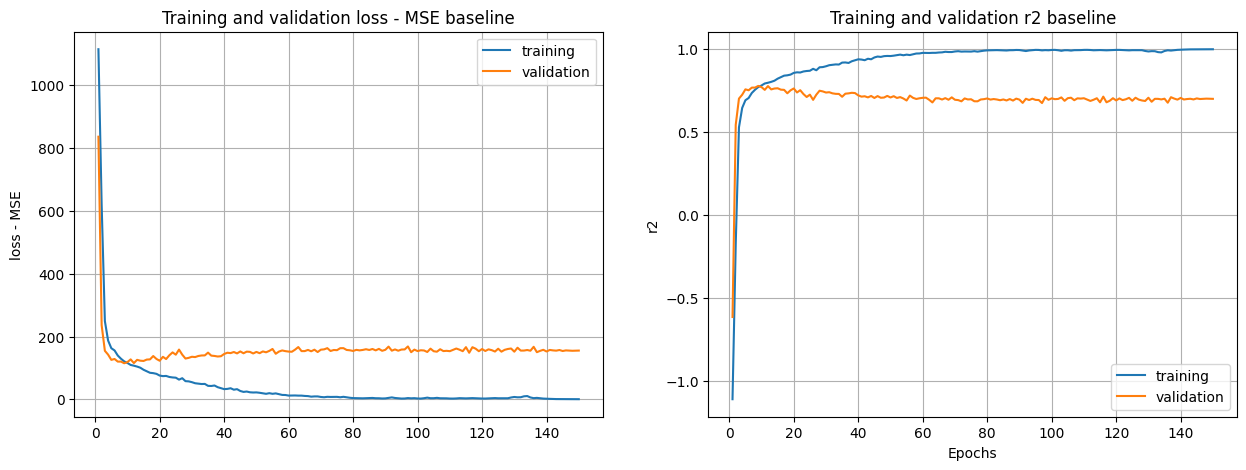

In [27]:
chosenKn = grid_result_kn.best_params_['model__k_init']
tf.random.set_seed(seed)
random.seed(seed)
mlp_kn = create_mlpk(chosenKn)
mlp_kn_hist = mlp_kn.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_kn_hist,'baseline',150)

In [28]:
get_best_epochs(mlp_kn_hist)

Best number of epochs 9


### activation funtion

In [29]:
# model default params for assessing activation and kernel initialization
# network = [256, 128, 64, 16, 8]
# batch size = 128
# opt = 'adam'

def create_mlpa(acti = 'relu'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=acti, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = acti))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
acti = ['relu','selu','elu', 'tanh', 'sigmoid']
epochs = np.arange(0,30)

pams_grid = dict(model__acti = acti, 
               epochs = epochs)

# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlpa,
                     batch_size = chosenBatch,
                     verbose=0)
grid_a = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_a = grid_a.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_a, 'Top results for activation' , 10)

Top results for activation
Best: 0.712502 using {'epochs': 21, 'model__acti': 'elu'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
107,"{'epochs': 21, 'model__acti': 'elu'}",0.810837,0.039068,0.712502,0.039068
67,"{'epochs': 13, 'model__acti': 'elu'}",0.783448,0.027462,0.709417,0.027462
97,"{'epochs': 19, 'model__acti': 'elu'}",0.803309,0.036668,0.708267,0.036668
72,"{'epochs': 14, 'model__acti': 'elu'}",0.789324,0.034897,0.708093,0.034897
77,"{'epochs': 15, 'model__acti': 'elu'}",0.792986,0.031328,0.707977,0.031328
127,"{'epochs': 25, 'model__acti': 'elu'}",0.820425,0.041408,0.705190,0.041408
92,"{'epochs': 18, 'model__acti': 'elu'}",0.803084,0.045543,0.703708,0.045543
137,"{'epochs': 27, 'model__acti': 'elu'}",0.818875,0.037631,0.703523,0.037631
112,"{'epochs': 22, 'model__acti': 'elu'}",0.804982,0.032643,0.703424,0.032643
82,"{'epochs': 16, 'model__acti': 'elu'}",0.798773,0.037095,0.702033,0.037095


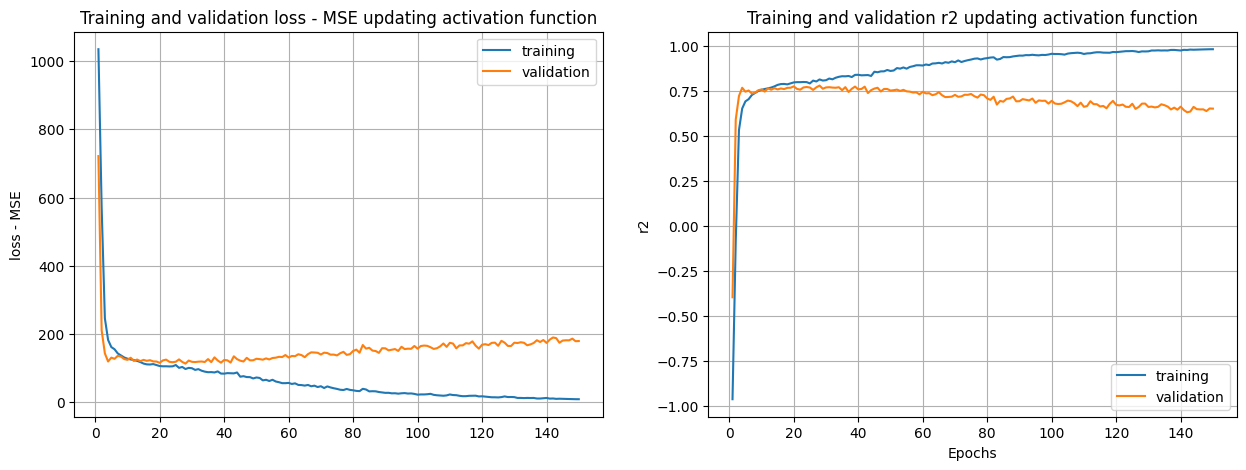

In [30]:
chosenActi = grid_result_a.best_params_['model__acti']
tf.random.set_seed(seed)
random.seed(seed)
mlp_a = create_mlpa(chosenActi)
mlp_a_hist = mlp_a.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_a_hist,'updating activation function',150)

In [31]:
get_best_epochs(mlp_a_hist)

Best number of epochs 28


### Selecting optimizer

In [32]:
# model default params for assessing optimization
# network = [256, 128, 64, 16]
# batch size = 128
# acti = 'selu' / kernel_init = 'uniform' 
def create_mlpopt(opt = 'Adam'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
opt = ['SGD', 'RMSprop', 'Adam']
epochs = np.arange(0,30)
pams_grid = dict(model__opt =opt, 
                  epochs = epochs)

# Build model and grid searcg
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpopt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_opt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_opt = grid_opt.fit(xtrain, ytrain)
summaryGridresult(grid_result_opt, 'Top resutls for optimizer' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.55420244 -1.53704717 -1.54778393         nan  0.44868093  0.03119583
         nan  0.65179493  0.53062285         nan  0.53335891  0.64218719
         nan  0.56023086  0.6696205          nan  0.62594425  0.69212618
         nan  0.6406778   0.70844755         nan  0.65675748  0.68272455
         nan  0.65268765  0.69568352         nan  0.58233589  0.68636525
         nan  0.68191906  0.66767261         nan  0.64600474  0.69130613
         nan  0.67121579  0.68620166         nan  0.67165324  0.66163041
         nan  0.68321644  0.68608429         nan  0.68227257  0.67148498
         nan  0.65895253  0.67496169         nan  0.60841448  0.66312996
         nan  0.49371556  0.69952798         nan  0.60945202  0.69197514
         nan  0.63520173  0.64841293         nan  0.60139257  0.64720688
         nan  0.65703

Top resutls for optimizer
Best: 0.708448 using {'epochs': 6, 'model__opt': 'Adam'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
20,"{'epochs': 6, 'model__opt': 'Adam'}",0.774812,0.027020,0.708448,0.027020
56,"{'epochs': 18, 'model__opt': 'Adam'}",0.827433,0.030049,0.699528,0.030049
26,"{'epochs': 8, 'model__opt': 'Adam'}",0.786220,0.036025,0.695684,0.036025
68,"{'epochs': 22, 'model__opt': 'Adam'}",0.842478,0.039984,0.692166,0.039984
17,"{'epochs': 5, 'model__opt': 'Adam'}",0.767476,0.037701,0.692126,0.037701
59,"{'epochs': 19, 'model__opt': 'Adam'}",0.824579,0.044567,0.691975,0.044567
35,"{'epochs': 11, 'model__opt': 'Adam'}",0.799529,0.053905,0.691306,0.053905
29,"{'epochs': 9, 'model__opt': 'Adam'}",0.778747,0.041373,0.686365,0.041373
38,"{'epochs': 12, 'model__opt': 'Adam'}",0.801354,0.046428,0.686202,0.046428
44,"{'epochs': 14, 'model__opt': 'Adam'}",0.817810,0.058571,0.686084,0.058571


#### Learning rate

In [33]:
chosenOpt = grid_result_opt.best_params_['model__opt']

def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=chosenOpt, 
               loss='mse', metrics=[RSquare()])
   return model

lr = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075]
epochs = np.arange(0,30)
pams_grid = dict(model__optimizer__learning_rate=lr,
                  epochs = epochs)


# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlplr,
                     batch_size = chosenBatch,
                     verbose=0)
grid_lr = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1,)
                        
grid_result_lr = grid_lr.fit(xtrain, ytrain)

pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_lr, 'Top results for learning rate' , 10)

Top results for learning rate
Best: 0.716047 using {'epochs': 23, 'model__optimizer__learning_rate': 0.0075}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
167,"{'epochs': 23, 'model__optimizer__learning_rate': 0.0075}",0.807608,0.038732,0.716047,0.038732
171,"{'epochs': 24, 'model__optimizer__learning_rate': 0.001}",0.812203,0.046148,0.712430,0.046148
166,"{'epochs': 23, 'model__optimizer__learning_rate': 0.005}",0.816445,0.042186,0.711572,0.042186
106,"{'epochs': 15, 'model__optimizer__learning_rate': 0.0005}",0.797025,0.039030,0.711402,0.039030
162,"{'epochs': 23, 'model__optimizer__learning_rate': 0.0005}",0.813552,0.041705,0.711257,0.041705
158,"{'epochs': 22, 'model__optimizer__learning_rate': 0.0025}",0.814627,0.046128,0.710783,0.046128
146,"{'epochs': 20, 'model__optimizer__learning_rate': 0.0075}",0.810783,0.044804,0.710597,0.044804
130,"{'epochs': 18, 'model__optimizer__learning_rate': 0.0025}",0.799205,0.035830,0.710449,0.035830
102,"{'epochs': 14, 'model__optimizer__learning_rate': 0.0025}",0.796982,0.038265,0.710048,0.038265
145,"{'epochs': 20, 'model__optimizer__learning_rate': 0.005}",0.814027,0.044300,0.709940,0.044300


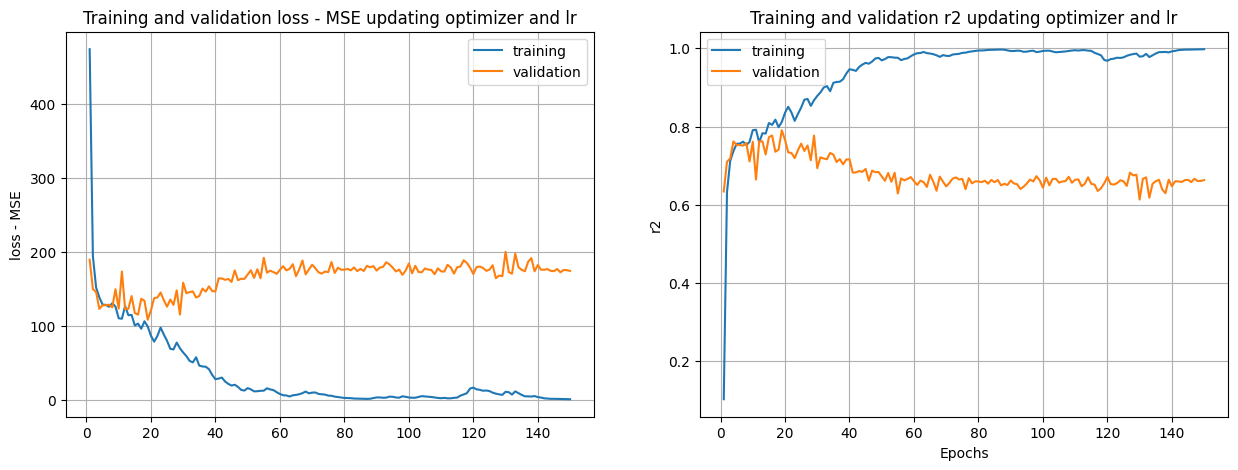

In [34]:
# visualize
chosenLr = grid_result_lr.best_params_['model__optimizer__learning_rate']
def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate = chosenLr)
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

tf.random.set_seed(seed)
random.seed(seed)
mlp_lr =  create_mlplr()
mlp_lr_hist= mlp_lr.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_lr_hist,'updating optimizer and lr',150)


In [35]:
get_best_epochs(mlp_lr_hist)

Best number of epochs 19


### Drop-out

In [36]:
# Drop oout
def create_mlpdpt(dpt = 0):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(dpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(dpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model
#Buil Learning rate for optimization function
dpt = [0, 0.1,0.2, 0.3, 0.4, 0.5]
epochs = np.arange(0,30)

pams_grid = dict(model__dpt=dpt,
                  epochs = epochs)

# Build model and grid searcg

tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpdpt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_dpt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_dpt = grid_dpt.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_dpt, 'Top results for drop-put rate' , 10)

Top results for drop-put rate
Best: 0.700992 using {'epochs': 10, 'model__dpt': 0}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
60,"{'epochs': 10, 'model__dpt': 0}",0.805000,0.039346,0.700992,0.039346
67,"{'epochs': 11, 'model__dpt': 0.1}",0.795896,0.028385,0.698396,0.028385
42,"{'epochs': 7, 'model__dpt': 0}",0.778076,0.026251,0.696758,0.026251
25,"{'epochs': 4, 'model__dpt': 0.1}",0.756928,0.039225,0.688673,0.039225
80,"{'epochs': 13, 'model__dpt': 0.2}",0.804578,0.023828,0.687678,0.023828
114,"{'epochs': 19, 'model__dpt': 0}",0.834932,0.018149,0.686498,0.018149
73,"{'epochs': 12, 'model__dpt': 0.1}",0.806959,0.048869,0.684880,0.048869
98,"{'epochs': 16, 'model__dpt': 0.2}",0.793835,0.035153,0.681729,0.035153
66,"{'epochs': 11, 'model__dpt': 0}",0.828351,0.076405,0.680809,0.076405
111,"{'epochs': 18, 'model__dpt': 0.3}",0.773472,0.026678,0.678909,0.026678


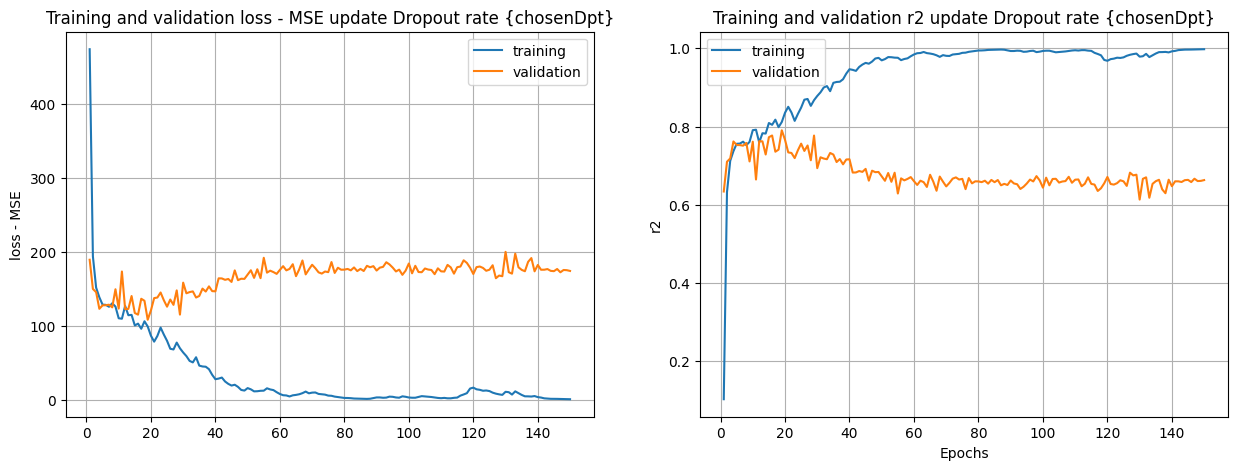

In [37]:
# Visualize
chosenDpt = grid_result_dpt.best_params_['model__dpt']
tf.random.set_seed(seed)
random.seed(seed)
mlp_dpt =  create_mlpdpt(chosenDpt)
mlp_dpt_hist= mlp_dpt.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_dpt_hist,'update Dropout rate {chosenDpt}',150)


### Final model

In [38]:
def create_mlp():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(chosenDpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(chosenDpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model

In [39]:
chosenEp = grid_result_dpt.best_params_['epochs']
tf.random.set_seed(seed)
random.seed(seed)
mlp_final = create_mlp()
mlp_final.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 256)               8960      
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_67 (Dense)            (None, 128)               32896     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_68 (Dense)            (None, 32)                4128      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_69 (Dense)            (None, 8)               

In [40]:
mlp_final.fit(xtrain, ytrain,
               epochs=chosenEp,
               batch_size=chosenBatch,
               verbose=0,)


In [41]:
test_lost_score, test_r2_score = mlp_final.evaluate(xtest, ytest)
test_pred = mlp_final.predict(xtest)

4/4 [==============================] - 0s 1ms/step


MSE in testing: 139.81512451171875, 
R2 in testing: 0.7448837757110596,
MAE in testing: 7.993715057459015, 
Precision of 10%: 0.49038461538461536


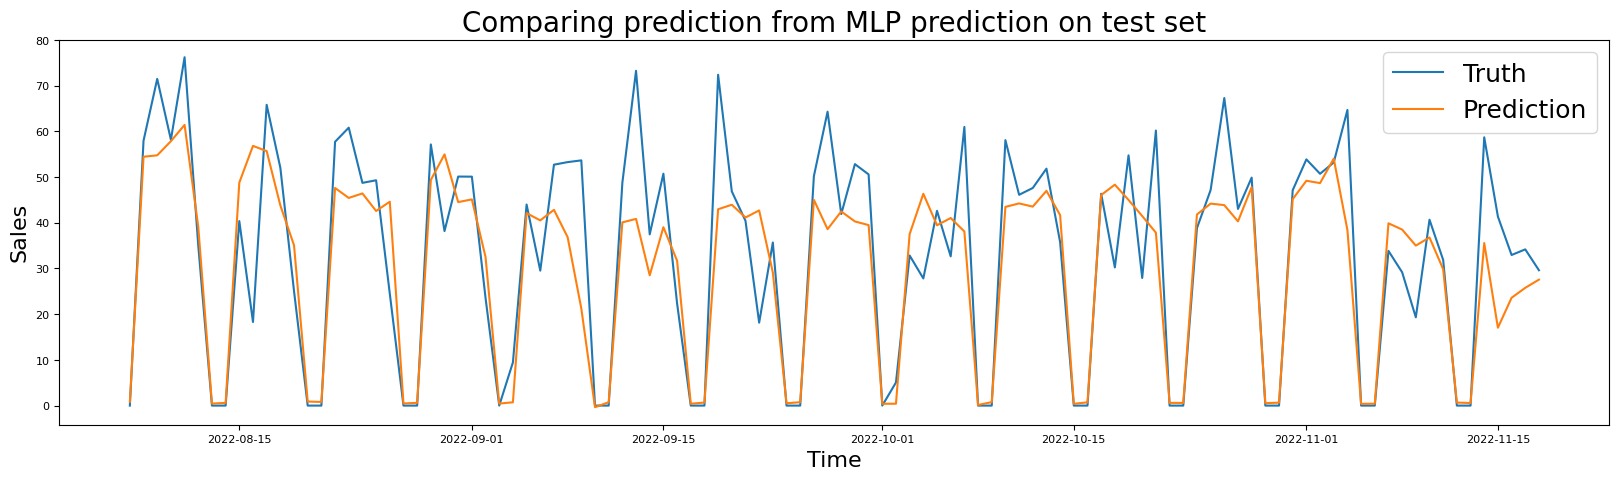

In [42]:

mae =  mean_absolute_error(ytest, test_pred)
pre = get_pre(ytest, test_pred, 0.1)

print(f'MSE in testing: {test_lost_score}, \nR2 in testing: {test_r2_score},\nMAE in testing: {mae}, \nPrecision of 10%: {pre}')

plotprediction(ytest_df, test_pred.flatten(), 'MLP prediction on test set')